# 本番のデータを使ってモデルを作る

接続テスト

In [1]:
import torch

print(f"Pytorchのバージョン：{torch.__version__}")

print(f"CUDAの利用可否：{torch.cuda.is_available()}")

device_num:int = torch.cuda.device_count()
print(f"発見されたGPUデバイス数：{device_num}")
for idx in range(device_num):
    print(f"デバイス番号：{idx} | デバイス名：{torch.cuda.get_device_name(idx)}")

Pytorchのバージョン：2.1.0.dev20230719+cu121
CUDAの利用可否：True
発見されたGPUデバイス数：1
デバイス番号：0 | デバイス名：NVIDIA GeForce RTX 3060 Ti


必要なライブラリをインポート

In [2]:
# Standard libraries
import os
import random
import shutil
import datetime

# Third-party libraries
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Jupyter magic command
%matplotlib inline

必要な関数を定義

In [3]:
# rawdata → 複数のフォルダへ振り分ける関数
# 引数：folder1_path, folder1_ratio, folder2_path, folder2_ratio, ...

def split_and_copy_data(*args):
    if len(args) % 2 != 0 or len(args) < 4:
        raise ValueError("Arguments should be even and at least consist of 2 folder paths and their ratios.")
    
    total_ratio = sum(args[1::2])
    if not 0.99 <= total_ratio <= 1.01:
        raise ValueError("Sum of all ratios should be close to 1 (or 100%).")
    
    # 1. Count files in rawdata/images
    rawdata_path = "../datasets/rawdata"
    rawdata_images_path = os.path.join(rawdata_path, "images")
    all_files = os.listdir(rawdata_images_path)
    paired_files = [f for f in all_files if f.endswith('.png') and f[:-4] + '.txt' in os.listdir(os.path.join(rawdata_path, "labels"))]
    
    paired_files_count = len(paired_files)
    print(f"Total paired files: {paired_files_count}")
    
    # Shuffle and split the files
    random.shuffle(paired_files)
    
    last_index = 0
    for i in range(0, len(args), 2):
        folder_path = args[i]
        ratio = args[i+1]
        
        images_folder_path = os.path.join(folder_path, 'images')
        labels_folder_path = os.path.join(folder_path, 'labels')
        
        # Clear the contents if the target folders are not empty.
        for subfolder in [images_folder_path, labels_folder_path]:
            if os.listdir(subfolder):
                for file in os.listdir(subfolder):
                    os.remove(os.path.join(subfolder, file))
                print(f"Contents in {subfolder} were deleted to proceed.")
        
        count_files_for_current_folder = int(paired_files_count * ratio)
        selected_files = paired_files[last_index:last_index + count_files_for_current_folder]
        last_index += count_files_for_current_folder
        
        # Copy paired png and txt files
        for f in selected_files:
            shutil.copy(os.path.join(rawdata_images_path, f), images_folder_path)
            shutil.copy(os.path.join(rawdata_path, "labels", f[:-4] + '.txt'), labels_folder_path)
        
        print(f"Copied {count_files_for_current_folder} paired files to {folder_path}")
    
    print("Finished copying files!")

# 実行例
# split_and_copy_data("../datasets/train", 0.8, "../datasets/valid", 0.2)
# split_and_copy_data("../datasets/train", 0.6, "../datasets/valid", 0.2, "../datasets/test", 0.2)


In [4]:
# 特定のフォルダ内のデータを削除する関数

def clear_data(directory_path):

    images_path = os.path.join(directory_path, "images")
    labels_path = os.path.join(directory_path, "labels")

    # imagesフォルダ内のファイルを削除
    for filename in os.listdir(images_path):
        file_path = os.path.join(images_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # ファイルまたはシンボリックリンクを削除
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # ディレクトリを削除
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

    # labelsフォルダ内のファイルを削除
    for filename in os.listdir(labels_path):
        file_path = os.path.join(labels_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # ファイルまたはシンボリックリンクを削除
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # ディレクトリを削除
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")
    
    # フォルダ名を取得してメッセージに使用
    directory_name = os.path.basename(directory_path)
    print(f"{directory_name} directory has been cleared!")

# 実行例
# clear_data("../datasets/train")
# clear_data("../datasets/valid")


モデルの作成

In [5]:
# rawdata → train,validへの振り分け
train_path = "../datasets/train"
valid_path = "../datasets/valid"
split_and_copy_data(train_path, 0.7, valid_path, 0.3)

Total paired files: 1372
Contents in ../datasets/train/images were deleted to proceed.
Contents in ../datasets/train/labels were deleted to proceed.
Copied 960 paired files to ../datasets/train
Contents in ../datasets/valid/images were deleted to proceed.
Contents in ../datasets/valid/labels were deleted to proceed.
Copied 411 paired files to ../datasets/valid
Finished copying files!


In [6]:
# ベースとなるmodelの読み込み
model = YOLO('yolov8x.pt')

In [7]:
# ベースのmodelに追加学習
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()
model.train(data="../datasets/data.yaml", imgsz=640, epochs=100 , batch=-1, device=0)
end.record()

torch.cuda.synchronize()
elapsed_time = start.elapsed_time(end) / 1000

print('---------------------------------')
print(f'学習時間 : {elapsed_time} 秒')

New https://pypi.org/project/ultralytics/8.0.189 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.188 🚀 Python-3.10.12 torch-2.1.0.dev20230719+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 7973MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=../datasets/data.yaml, epochs=100, patience=50, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=Fa

---------------------------------
学習時間 : 6302.71 秒


In [8]:
# 完成したmodelの性能を評価
metrics = model.val()

Ultralytics YOLOv8.0.188 🚀 Python-3.10.12 torch-2.1.0.dev20230719+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 7973MiB)
Model summary (fused): 268 layers, 68128383 parameters, 0 gradients
val: Scanning /home/kotameyan/Programing/labo/workspace/using_maindata/datasets/valid/labels.cache... 411 images, 0 backgrounds, 0 corrupt: 100%|██████████| 411/411 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 137/137 [00:12<00:00, 11.06it/s]
                   all        411       2490      0.734      0.796       0.84      0.512
             flowering        411        317      0.851       0.71      0.839      0.546
             growing_g        411        922      0.841      0.648      0.831      0.421
             growing_w        411        486      0.617      0.853      0.785      0.469
              nearly_m        411        348      0.641      0.879      0.859      0.544
                mature        411        417    

In [9]:
# train,valid内のデータを削除
clear_data(train_path)
clear_data(valid_path)

train directory has been cleared!
valid directory has been cleared!


モデルを使用

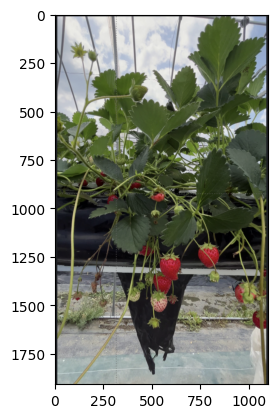

In [10]:
# 画像識別に使う画像を確認

before_img_1_addr = "../datasets/predict/predict_1.png"

before_img_1 = plt.imread(before_img_1_addr)
plt.imshow(before_img_1)
plt.show()

In [11]:
# モデルを使って画像識別

model.predict(before_img_1_addr, save=True)


image 1/1 /home/kotameyan/Programing/labo/workspace/using_maindata/code/../datasets/predict/predict_1.png: 640x384 3 nearly_ms, 5 matures, 56.3ms
Speed: 0.9ms preprocess, 56.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'flowering', 1: 'growing_g', 2: 'growing_w', 3: 'nearly_m', 4: 'mature'}
 orig_img: array([[[48, 43, 40],
         [48, 43, 40],
         [48, 43, 40],
         ...,
         [48, 43, 40],
         [48, 43, 40],
         [48, 43, 40]],
 
        [[48, 43, 40],
         [48, 43, 40],
         [48, 43, 40],
         ...,
         [48, 43, 40],
         [48, 43, 40],
         [48, 43, 40]],
 
        [[48, 43, 40],
         [48, 43, 40],
         [48, 43, 40],
         ...,
         [48, 43, 40],
         [48, 43, 40],
         [48, 43, 40]],
 
        ...,
 
        [[36, 32, 30],
         [36, 32, 30],
         [36, 32, 30],
         ...,
         [36, 32, 30],
         [36, 32, 30],
         [36, 32, 30]],
 
        [[36, 32, 30],
         [36, 32, 30],
         [36, 32, 30],
         ...,
         [36, 32, 30],
         [36, 32, 30],
 

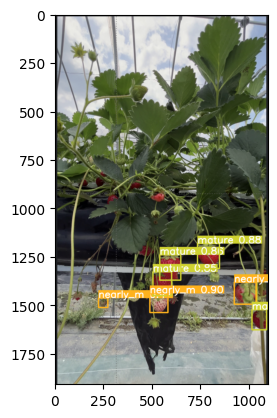

In [12]:
# 識別結果を出力

after_img_1_addr = "./runs/detect/predict/predict_1.png"

after_img_1 = plt.imread(after_img_1_addr)
plt.imshow(after_img_1)
plt.show()

runsを保存する

In [13]:
# 現在日時を取得

dt_now = datetime.datetime.now()
print(dt_now)

2023-09-30 01:27:39.190588


In [14]:
# 現在日時をもとにrunsフォルダの名前を変更

runs_add = dt_now.strftime("%m_%d_%H_%M")
os.rename("runs", f"runs_{runs_add}")

In [15]:
# runs_{runs_add}フォルダをruns_archiveフォルダに移動

shutil.move(f"runs_{runs_add}", f"runs_archive/runs_{runs_add}")

'runs_archive/runs_09_30_01_27'